In [2]:
from google.colab import drive

In [5]:
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


# 1.Import all the required libraries

In [32]:
import pandas as pd
import pathlib
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import cv2
from random import randint
from sklearn import preprocessing
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization, GlobalAveragePooling2D
from keras import optimizers
from keras.optimizers import Adam 
from keras import regularizers
from keras import layers
import tensorflow as tf


In [7]:

labels = pd.read_csv("/content/gdrive/My Drive/Labels.csv")


## get unique labels and index

In [17]:
df1 = labels.copy()
rows = []
for row in df1.drop_duplicates('Label').index:
  rows.append(row)


### Get the shape

In [18]:
print(labels.shape)
print(labels.size)

(4750, 1)
4750


In [19]:

data = pathlib.Path('/content/gdrive/My Drive/images.npy') 
images  = np.load(data)

In [20]:
 def show_img(images, labels, list):    
    imgs = images[list]
    lbl = labels.to_numpy()[list]
    _, figs = plt.subplots(1, 12, figsize=(12 * 3, 3))
    for fig, img, label in zip(figs, imgs, lbl):
        fig.imshow(img)
        ax = fig.axes
        ax.set_title(label[0])
        ax.title.set_fontsize(20)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

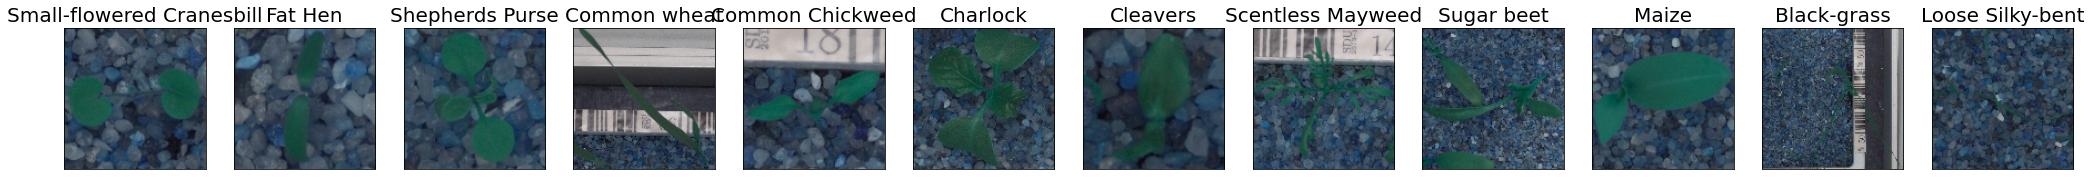

In [202]:
#labels.to_numpy()
show_img(images, labels, rows)

In [21]:
labels.Label.unique()

array(['Small-flowered Cranesbill', 'Fat Hen', 'Shepherds Purse',
       'Common wheat', 'Common Chickweed', 'Charlock', 'Cleavers',
       'Scentless Mayweed', 'Sugar beet', 'Maize', 'Black-grass',
       'Loose Silky-bent'], dtype=object)

## 2. Pre processing with GaussianBlur

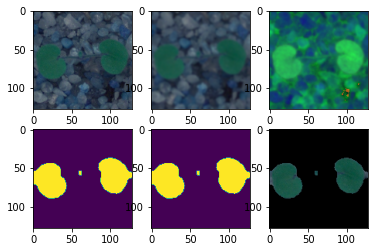

In [22]:
newImages = []
examples = []; getEx = True
for img in images:
    # Use gaussian blur
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    
    # Convert to HSV image
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    
    # Create mask (parameters - green color range)
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Create bool mask
    bMask = mask > 0  
    
    # Apply the mask
    clear = np.zeros_like(img, np.uint8)  # Create empty image
    clear[bMask] = img[bMask]  # Apply boolean mask to the origin image
    
    newImages.append(clear)  # Append image without backgroung
    
    # Show examples
    if getEx:
        plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
        plt.subplot(2, 3, 2); plt.imshow(blurImg)  # Blur image
        plt.subplot(2, 3, 3); plt.imshow(hsvImg)  # HSV image
        plt.subplot(2, 3, 4); plt.imshow(mask)  # Mask
        plt.subplot(2, 3, 5); plt.imshow(bMask)  # Boolean mask
        plt.subplot(2, 3, 6); plt.imshow(clear)  # Image without background
        getEx = False
newImages = np.asarray(newImages)

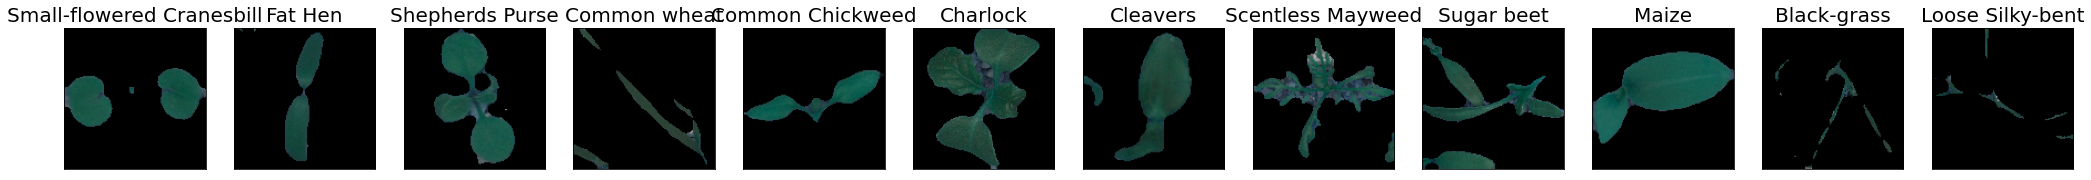

In [23]:
show_img(newImages, labels, rows)

## Normalization

In [24]:
#Normalization
newImages = newImages/255


## One hot encoding and first label

In [26]:
#One hot encodings

print(labels['Label'][1])
le = preprocessing.LabelEncoder()
le.fit(labels['Label'])
print("Classes: " + str(le.classes_))
encodeLabels = le.transform(labels['Label'])

# Make labels categorical
clearTrainLabel = to_categorical(encodeLabels)
num_classes = clearTrainLabel.shape[1]
print("Number of classes: " + str(num_classes))

# Plot of label types numbers
#labels['Label'].value_counts().plot(kind='bar')

print(clearTrainLabel[0])


Small-flowered Cranesbill
Classes: ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
Number of classes: 12
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [27]:
clearTrainLabel

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [28]:
clearTrainLabel.shape

(4750, 12)

In [29]:

seed = 31
# first split
X_train, X_test, y_train, y_test = train_test_split(newImages,clearTrainLabel, test_size=0.3,random_state=seed) 
# second split on validation
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_test, y_test, test_size=0.5, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print("validation set")
print(X_train1.shape)
print(X_val1.shape)
print(y_train1.shape)
print(y_val1.shape)

(3325, 128, 128, 3)
(1425, 128, 128, 3)
(3325, 12)
(1425, 12)
validation set
(712, 128, 128, 3)
(713, 128, 128, 3)
(712, 12)
(713, 12)


## Data augementation before sending to Karas model 
Shape is in format that we can send to model

In [30]:


datagen = ImageDataGenerator(
        rotation_range=180,  # randomly rotate images in the range
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically 
        horizontal_flip=True,  # randomly flip images horizontally
        vertical_flip=True  # randomly flip images vertically
    )  
datagen.fit(X_train)

## Model Building
4 convolutional layers
2 Max pooling layers
3 Dense layers
Dropouts added
Adam Optimizer and categorical cross entropy






In [42]:


model = Sequential() 

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3))) 
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))


model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2))) 
model.add(Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))


model.add(layers.Conv2D(128, (3, 3),  activation='relu'))
model.add(layers.Conv2D(256, (3, 3),  activation='relu'))
model.add(layers.Conv2D(512, (3, 3),  activation='relu'))
model.add(layers.MaxPooling2D((2, 2))) 
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GlobalAveragePooling2D())# like flatten
model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01) ))# L1 regularization
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))) # L2 regularization
model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(0.01))) # L1 & L2 regularization
#model.add(BatchNormalization())
#model.add(layers.Dense(256, activation='relu'))

model.add(layers.Dense(12, activation='softmax'))
#optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#categorical_crossentropy when labels hot encoded
opt = optimizers.Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
#model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
model_A = model
model_A.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 63, 63, 32)        128       
_________________________________________________________________
dropout_24 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
dropout_25 (Dropout)         (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 59, 59, 128)      

## Fit with call backs

In [43]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=6,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
#X_train, X_test, y_train, y_test
sig_history = model_A.fit_generator(datagen.flow(X_train, y_train, batch_size=34), epochs=80, validation_data=(X_test, y_test), 
                                    verbose=2,callbacks=[learning_rate_reduction])


Epoch 1/80
98/98 - 38s - loss: 61.6287 - accuracy: 0.3471 - val_loss: 55.8354 - val_accuracy: 0.0456
Epoch 2/80
98/98 - 37s - loss: 49.1844 - accuracy: 0.5374 - val_loss: 45.3767 - val_accuracy: 0.0751
Epoch 3/80
98/98 - 37s - loss: 38.4851 - accuracy: 0.6174 - val_loss: 37.2533 - val_accuracy: 0.0940
Epoch 4/80
98/98 - 37s - loss: 29.3705 - accuracy: 0.6499 - val_loss: 30.5454 - val_accuracy: 0.0596
Epoch 5/80
98/98 - 37s - loss: 21.7501 - accuracy: 0.6635 - val_loss: 21.3520 - val_accuracy: 0.0996
Epoch 6/80
98/98 - 37s - loss: 15.5824 - accuracy: 0.6707 - val_loss: 14.4758 - val_accuracy: 0.1923
Epoch 7/80
98/98 - 37s - loss: 10.8781 - accuracy: 0.6614 - val_loss: 9.5110 - val_accuracy: 0.3740
Epoch 8/80
98/98 - 37s - loss: 7.5881 - accuracy: 0.6538 - val_loss: 6.5609 - val_accuracy: 0.5291
Epoch 9/80
98/98 - 37s - loss: 5.6858 - accuracy: 0.6505 - val_loss: 5.1594 - val_accuracy: 0.5874
Epoch 10/80
98/98 - 37s - loss: 4.8262 - accuracy: 0.6328 - val_loss: 4.6072 - val_accuracy: 0.5

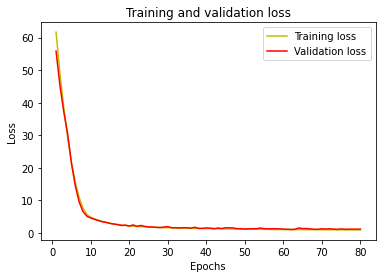

In [44]:
loss = sig_history.history['loss']
val_loss = sig_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

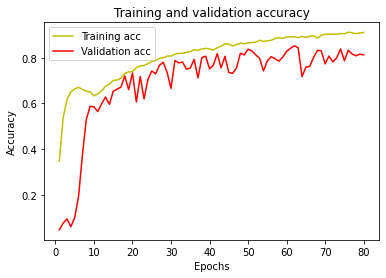

In [45]:
acc = sig_history.history['accuracy']
val_acc = sig_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Evaluation of the Model

In [46]:

# Final evaluation of the model
#X_train, X_test, y_train, y_test
scores = model_A.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Baseline Error: 18.74%


In [47]:
print(model_A.evaluate(X_train, y_train))  # Evaluate on train set
print(model_A.evaluate(X_test, y_test))  # Evaluate on test set
print(model_A.evaluate(X_val1, y_val1)) # Evaluate on validation set


104/104 [==============================] - 10s 94ms/step - loss: 1.1282 - accuracy: 0.8376
[1.1281518936157227, 0.8375939726829529]
45/45 [==============================] - 4s 83ms/step - loss: 1.1787 - accuracy: 0.8126
[1.178682565689087, 0.8126316070556641]
23/23 [==============================] - 2s 100ms/step - loss: 1.1756 - accuracy: 0.8036
[1.1755616664886475, 0.8036465644836426]


## Print Confusion Matrix

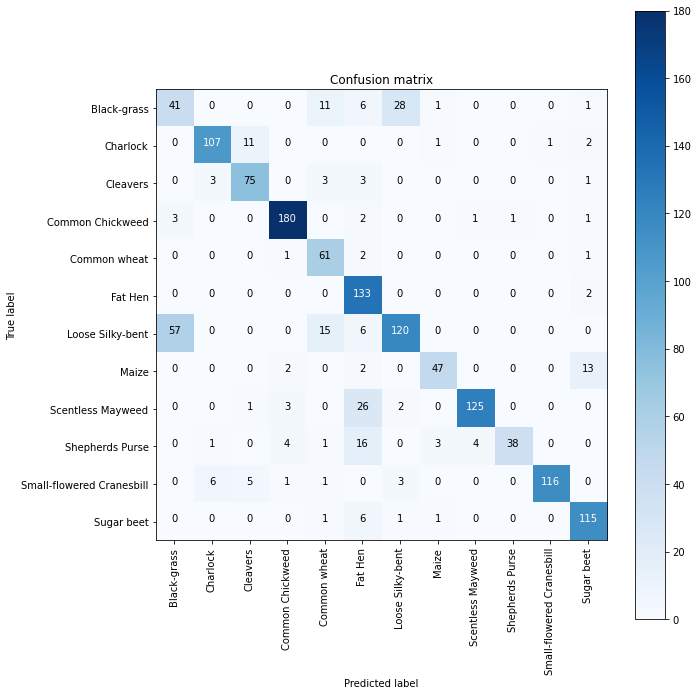

In [48]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#X_train, X_test, y_train, y_test
# Predict the values from the validation dataset
predY = model_A.predict(X_test)
predYClasses = np.argmax(predY, axis = 1) 
trueY = np.argmax(y_test, axis = 1) 

# confusion matrix
confusionMTX = confusion_matrix(trueY, predYClasses) 

# plot the confusion matrix
plot_confusion_matrix(confusionMTX, classes = le.classes_) 

In [50]:

ynew = model.predict_classes(X_test)
# show the inputs and predicted outputs



Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


## Reults after prediction

In [55]:
from numpy import  argmax


print("Actual:", argmax(y_test[2]))
print("Predicted:", ynew[2])

print("Actual:", argmax(y_test[3]))
print("Predicted:", ynew[3])

print("Actual:", argmax(y_test[33]))
print("Predicted:", ynew[33])

print("Actual:", argmax(y_test[36]))
print("Predicted:", ynew[36])

print("Actual:", argmax(y_test[59]))
print("Predicted:", ynew[59])

Actual: 2
Predicted: 2
Actual: 0
Predicted: 0
Actual: 11
Predicted: 11
Actual: 10
Predicted: 10
Actual: 3
Predicted: 3


All were predicted correctly